In [1]:
# import robot_loader from scripts
import pinocchio as pin
import crocoddyl
import os
import numpy as np
from scripts.robot_loader import *
import meshcat.geometry as mg

# load model on Meshcat
model, collision_model, visual_model, robot_visualizer, viz = launch_visualization()

print(f"--- Pinocchio model datas ---")
print(f"Robot name: {model.name}")
print(f"Configuration dimension (nq): {model.nq}")
print(f"Velocity dimension (nv): {model.nv}")

data = model.createData()
robot_visualizer.data = data

# Display some frames
frames_to_display = ["pelvis", "left_ground", "right_ground"]
frame_ids = [model.getFrameId(frame_name) for frame_name in frames_to_display]
robot_visualizer.displayFrames(True, frame_ids)

# Display the robot on in initial position, with his feets close to the ground
q0 = pin.neutral(model)
q0[2] = 1.03
robot_visualizer.display(q0)
pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

--- Searching for robot paths ---
Detected project root directory: /home/cpene/Documents/robot_playground
Asset paths verified.
Detected urdf file: /home/cpene/Documents/robot_playground/robot_models/h1_2_description/h1_2_handless.urdf
Detected mesh directory: /home/cpene/Documents/robot_playground/robot_models/h1_2_description
Launching MeshCat...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Adding a grid to represent the ground.
Loading robot model into Pinocchio...
Pinocchio model loaded successfully.
Frame 'left_ground' added successfully.
Frame 'right_ground' added successfully.

Environment is ready !
--- Pinocchio model datas ---
Robot name: h1_2
Configuration dimension (nq): 34
Velocity dimension (nv): 33


In [2]:
# Initial guess
# I want to provide a "valide" command as an input
v0 = np.zeros(model.nv)
a0 = np.zeros(model.nv)
full_gravity_torques = pin.rnea(model, data, q0, v0, a0)
u0 = full_gravity_torques[6:] # this represent the command to counter gravity.

x0 = np.concatenate([q0, v0]) # This represent initial configuration with v = 0

In [3]:
# Define a trajectory to follow
pin.forwardKinematics(model, data, q0, v0)
pin.updateFramePlacements(model, data)
pin.centerOfMass(model, data, q0, v0)

com_initial = data.com[0].copy()
print(f"Initial position of CoM (x, y, z): {np.round(com_initial, 3)}")

com_final = com_initial.copy()
com_final[2] -= 0.30

print(f"Final position of CoM (x, y, z):   {np.round(com_final, 3)}")

TRAJECTORY_STEP = 200 # 20cm trajectory should need 2 seconds with TIME_STEP = 0.033
TIME_STEP = 0.033
HORIZON_LENGTH = 1

reference_com_trajectory = []
for j in range(TRAJECTORY_STEP + HORIZON_LENGTH):
    alpha = float(j) / (TRAJECTORY_STEP - 1)
    alpha = min(alpha, 1.0)
    
    com_ref_j = (1 - alpha) * com_initial + alpha * com_final
    reference_com_trajectory.append(com_ref_j)
    

Initial position of CoM (x, y, z): [0.011 0.001 0.94 ]
Final position of CoM (x, y, z):   [0.011 0.001 0.64 ]


In [5]:
# I want to chain OCP problem in order to solve a small part of a trajectory
from ocp.ocp_builder import OCPBuilder
from ocp.cost_manager import CostModelManager
from ocp.contact_manager import ContactModelManager


left_foot_id = model.getFrameId("left_ground")
right_foot_id = model.getFrameId("right_ground")
contact_frame_ids = [left_foot_id, right_foot_id]

x_current = x0
u_reg = u0

u_trajectory = []
x_trajectory = [x_current]
com_trajectory = []

trajectory_data = [] 

xs_init = [x_current for _ in range(HORIZON_LENGTH + 1)] 
us_init = [u_reg for _ in range(HORIZON_LENGTH)]

ocp_build = OCPBuilder(initial_state=x_current,
                                 rmodel=model,
                                 dt=TIME_STEP,
                                 horizon_length=HORIZON_LENGTH)

for i in range(TRAJECTORY_STEP):

    ocp_build.set_initial_state(x_current)
    
    # create contacts
    running_contact_managers = []
    for j in range (HORIZON_LENGTH):
        contact_manager_i = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data)
        contact_manager_i.add_contact_6D("left_ground") \
                         .add_contact_6D("right_ground")
        running_contact_managers.append(contact_manager_i)
    
    terminal_contact_manager = ContactModelManager(ocp_build.state, ocp_build.actuation, model, data) \
            .add_contact_6D("left_ground") \
            .add_contact_6D("right_ground")
    
    # DEBUG contacts
    #terminal_contact_manager.display_contacts()

    # create contacts
    running_cost_managers = []
    for j in range (HORIZON_LENGTH):  
        cost_manager_i = CostModelManager(ocp_build.state, ocp_build.actuation)
        cost_manager_i.add_regulation_state_cost(x_ref=x_current, weight=0.001) \
                      .add_regulation_control_cost(u_ref=u_reg, weight=0.001) \
                      .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 200.0)
    
        running_cost_managers.append(cost_manager_i)
        
    terminal_cost_manager = CostModelManager(ocp_build.state, ocp_build.actuation)
    terminal_cost_manager.add_CoM_position_cost(reference_com_trajectory[i + HORIZON_LENGTH], 100.0) \
                         .add_contact_friction_cone_cost(contact_frame_ids, 0.7, 200.0)
    
    # DEBUG
    #terminal_cost_manager.display_costs()
    
    # finalize OCP and solve
    problem = ocp_build.build(running_cost_managers, terminal_cost_manager, running_contact_managers, terminal_contact_manager)
    solver = crocoddyl.SolverFDDP(problem)
    MAX_ITER = 50
    converged = solver.solve(xs_init, us_init, MAX_ITER)
    if converged:
        print(f"SUCCESS: FDDP {i} converged in {solver.iter} iterations.")
    else:
        print(f"FAILURE: FDDP {i} did not converge.")
        break

    # get result from solver to be used as next input
    u_optimal = solver.us[0]
    x_next = solver.xs[1]

    # Save trajectory data
    trajectory_data.append(solver.problem.runningDatas[0])
    u_trajectory.append(u_optimal)
    x_trajectory.append(x_next)

        
    # update model
    q_next = x_next[:model.nq]
    v_next = x_next[model.nq:]
    pin.forwardKinematics(model, data, q_next, v_next)
    pin.centerOfMass(model, data, q_next, v_next)
    pin.updateFramePlacements(model, data)

    com_trajectory.append(data.com[0].copy())

    x_current = x_next
    u_reg = u_optimal
    
    # warm start
    xs_list = list(solver.xs)
    us_list = list(solver.us)
    xs_init = xs_list[1:] + [xs_list[-1]]
    us_init = us_list[1:] + [us_list[-1]]


SUCCESS: FDDP 0 converged in 12 iterations.
SUCCESS: FDDP 1 converged in 13 iterations.
SUCCESS: FDDP 2 converged in 20 iterations.
SUCCESS: FDDP 3 converged in 17 iterations.
SUCCESS: FDDP 4 converged in 34 iterations.
SUCCESS: FDDP 5 converged in 17 iterations.
SUCCESS: FDDP 6 converged in 17 iterations.
FAILURE: FDDP 7 did not converge.


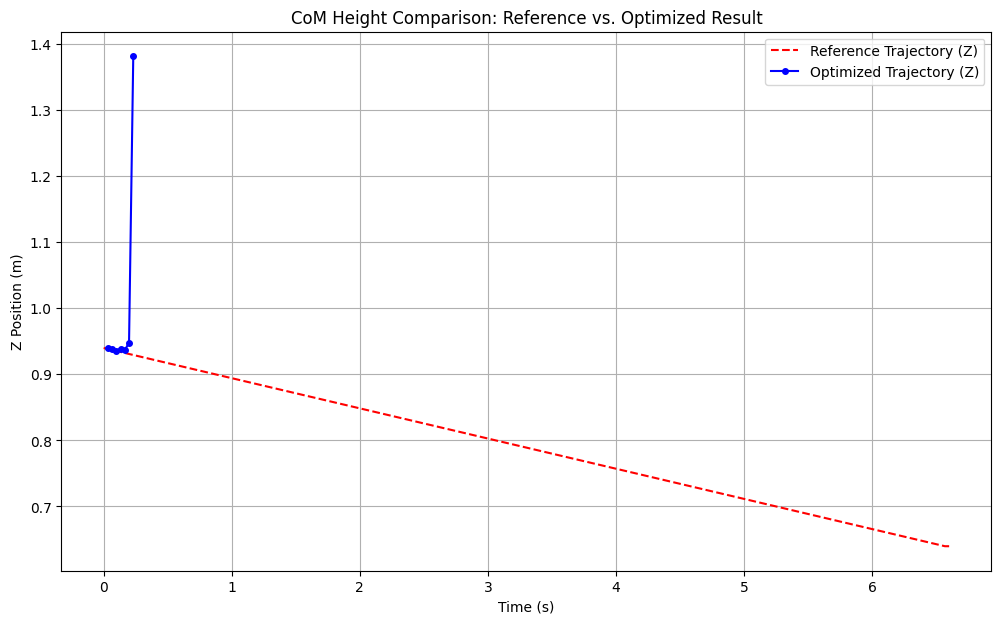

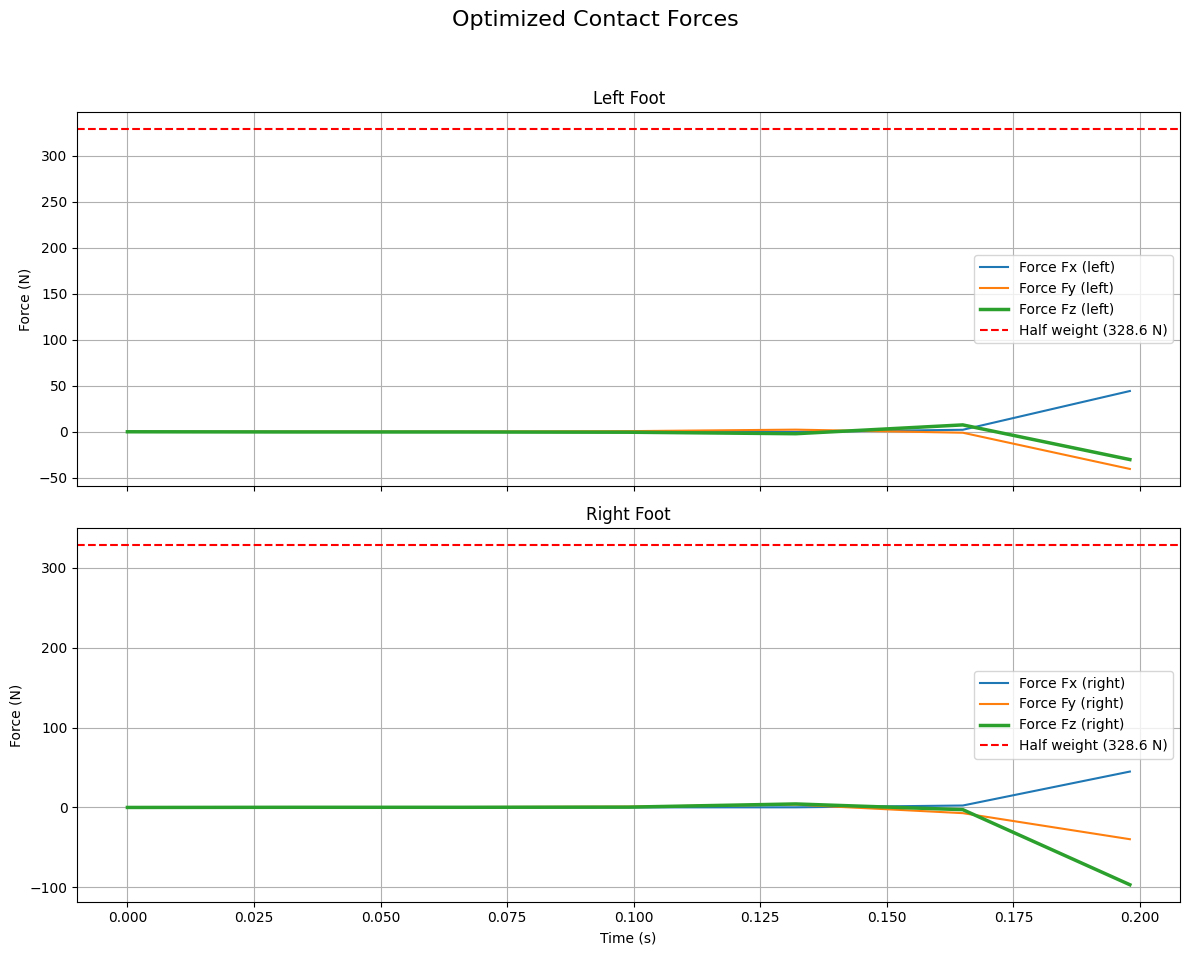

In [7]:
# --- ANALYSIS AND PLOTTING SCRIPT (WITH REFERENCE WEIGHT LINE) ---
import numpy as np
import matplotlib.pyplot as plt
import pinocchio as pin

# --- 1. Prepare data for the REFERENCE TRAJECTORY ---

# Extract the Z coordinate from the reference trajectory
z_reference = [com[2] for com in reference_com_trajectory]

# Create a time axis for the entire duration of the reference
# We take up to TRAJECTORY_STEP for the main comparison
time_axis_reference = np.arange(TRAJECTORY_STEP + 1) * TIME_STEP

# We only keep the part of the reference trajectory that corresponds to the simulation
z_reference_to_plot = z_reference[:TRAJECTORY_STEP + 1]


# --- 2. Prepare data for the OPTIMIZED TRAJECTORY (RESULT) ---

# The number of steps the optimization actually succeeded
num_successful_steps = len(com_trajectory)

# We can only plot the result if at least one step was successful
if num_successful_steps > 0:
    # Extract the Z coordinate from the optimization result
    z_optimized = [com[2] for com in com_trajectory]
    # The time axis for the result starts at t=TIME_STEP and goes up to the last successful step
    time_axis_optimized = np.arange(1, num_successful_steps + 1) * TIME_STEP


# --- 3. Create the comparative plot ---

plt.figure(figsize=(12, 7))

# Plot the reference trajectory (what we wanted)
plt.plot(time_axis_reference, z_reference_to_plot, 'r--', label="Reference Trajectory (Z)")

# Plot the optimized trajectory if it exists (what we got)
if num_successful_steps > 0:
    plt.plot(time_axis_optimized, z_optimized, 'b-o', markersize=4, label="Optimized Trajectory (Z)")

# Add a title and labels to make the plot readable
plt.title("CoM Height Comparison: Reference vs. Optimized Result")
plt.xlabel("Time (s)")
plt.ylabel("Z Position (m)")
plt.grid(True)
plt.legend()

# Display the plot
plt.show()

# Display a message if no data was generated by the optimizer
if num_successful_steps == 0:
    print("Warning: The `com_trajectory` list is empty. The optimization did not complete any steps.")

# Check if we have data to analyze
if not trajectory_data:
    print("The trajectory_data list is empty. No data to plot.")
else:
    # --- Step 1: Data Extraction ---
    left_wrenches = []
    right_wrenches = []

    # Iterate over our list of data collected at each MPC step
    for data in trajectory_data:
        diff_data = data.differential
        contact_datas = diff_data.multibody.contacts
        
        f_left = contact_datas.contacts['left_ground_contact'].f.vector
        f_right = contact_datas.contacts['right_ground_contact'].f.vector
        
        left_wrenches.append(f_left)
        right_wrenches.append(f_right)

    # Convert to numpy arrays and select linear forces
    left_wrenches = np.array(left_wrenches)
    right_wrenches = np.array(right_wrenches)
    
    # Linear forces are the last 3 elements of the spatial force vector
    left_forces = left_wrenches[:, 3:6]
    right_forces = right_wrenches[:, 3:6]
    
    # Create the time axis
    # Ensure that the TIME_STEP (or dt) variable is well defined
    time_axis = np.arange(len(left_forces)) * TIME_STEP

    # --- Step 2: Plotting (requested style) ---
    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle('Optimized Contact Forces', fontsize=16)

    # Graph for the left foot
    axs[0].plot(time_axis, left_forces[:, 0], label="Force Fx (left)")
    axs[0].plot(time_axis, left_forces[:, 1], label="Force Fy (left)")
    axs[0].plot(time_axis, left_forces[:, 2], label="Force Fz (left)", linewidth=2.5)
    axs[0].set_title("Left Foot")
    axs[0].set_ylabel("Force (N)")
    axs[0].grid(True)

    # Graph for the right foot
    axs[1].plot(time_axis, right_forces[:, 0], label="Force Fx (right)")
    axs[1].plot(time_axis, right_forces[:, 1], label="Force Fy (right)")
    axs[1].plot(time_axis, right_forces[:, 2], label="Force Fz (right)", linewidth=2.5)
    axs[1].set_title("Right Foot")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Force (N)")
    axs[1].grid(True)

    # Display the robot's weight as a reference
    try:
        # We use 'model', which is the name of your Pinocchio model
        robot_weight = pin.computeTotalMass(model) * 9.81
        half_weight = robot_weight / 2
        
        # Add the horizontal line on each subplot
        axs[0].axhline(y=half_weight, color='r', linestyle='--', label=f'Half weight ({half_weight:.1f} N)')
        axs[1].axhline(y=half_weight, color='r', linestyle='--', label=f'Half weight ({half_weight:.1f} N)')
    except Exception as e:
        print(f"Could not display the robot's weight. Error: {e}")

    # Add legends
    axs[0].legend()
    axs[1].legend()

    # Final layout adjustment and display
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [52]:
# Launch the simulation
import time
print("Starting animation...")

TIME_STEP = 0.033

q_trajectory = [x[:model.nq] for x in x_trajectory]

for q in q_trajectory:

    # Send q to robot visualization
    robot_visualizer.display(q)

    # dt is TIME_STEP
    time.sleep(TIME_STEP)

print("\nAnimation end.")

Starting animation...

Animation end.
